<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/main/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [91]:
# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Decomposição da Série Temporal

In [92]:
df_loja1_serie_temporal_agregada = pd.read_csv('loja1.csv')

import numpy as np
import tensorflow as tf

df_loja1_serie_temporal_agregada = reduce_mem_usage(df_loja1_serie_temporal_agregada)

n_periods = 1913

# eliminar as colunas indesejadas para a construção da série temporal
df_time_series = pd.DataFrame(data={"Vendas": df_loja1_serie_temporal_agregada['Vendas_do_dia'].tolist()}, index=df_loja1_serie_temporal_agregada['date'])

Mem. usage decreased to  0.05 Mb (63.8% reduction)


In [93]:
df_loja1_serie_temporal_agregada

,date,wm_yr_wk,wday,month,year,d,evento,Vendas_do_dia,week_group
0,2011-01-29,11101,1,1,2011,d_1,0,4337,0
1,2011-01-30,11101,2,1,2011,d_2,0,4155,0
2,2011-01-31,11101,3,1,2011,d_3,0,2816,1
3,2011-02-01,11101,4,2,2011,d_4,0,3051,1
4,2011-02-02,11101,5,2,2011,d_5,0,2630,1
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,0,3722,1
1909,2016-04-21,11612,6,4,2016,d_1910,0,3709,1
1910,2016-04-22,11612,7,4,2016,d_1911,0,4387,1
1911,2016-04-23,11613,1,4,2016,d_1912,0,5577,0


In [94]:
print(df_loja1_serie_temporal_agregada.columns)

Index(['date', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'evento',
       'Vendas_do_dia', 'week_group'],
      dtype='object')


In [95]:
print(df_time_series)

            Vendas
date              
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
...            ...
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113

[1913 rows x 1 columns]


## Carregar dados (agora concatenados)

In [96]:
df_loja1_RNN = reduce_mem_usage(df_loja1_serie_temporal_agregada)

Mem. usage decreased to  0.05 Mb (0.0% reduction)


# Treino de Modelos

##### Rede Neuronal Recurrente (RNN)

In [97]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

import numpy as np

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8, 6]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 7]  # Access single column directly

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

print(selected_output_column.values)

# Fit scaler to the data and transform it
selected_input_columns = scaler.fit_transform(selected_input_columns)
selected_output_column = scaler.fit_transform(selected_output_column.values.reshape(-1, 1))

import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

# Assuming selected_input_columns and selected_output_column are arrays or lists
input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]

# Assuming both input_data and targets are arrays or lists
sequence_length = 7
sequences = [(input_data[i:i+sequence_length], targets[i+sequence_length]) for i in range(len(input_data) - sequence_length)]

# Extract input sequences and targets
input_sequences = [seq[0] for seq in sequences]
target_values = [seq[1] for seq in sequences]

# Convert lists to TensorFlow tensors
input_sequences_tensor = tf.constant(input_sequences, dtype=tf.float32)
target_values_tensor = tf.constant(target_values, dtype=tf.float32)

# Create a TensorFlow dataset from tensors
dataset = tf.data.Dataset.from_tensor_slices((input_sequences_tensor, target_values_tensor))

# Shuffle and batch your dataset
batch_size = 32
buffer_size = len(sequences)
dataset = dataset.shuffle(buffer_size).batch(batch_size)

for batch in dataset:
    inputs, target = batch
    # Now you can use inputs and target for training
    break

[4337 4155 2816 ... 4387 5577 6113]


In [98]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 7, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [99]:
inputs, targets = batch

len(inputs)

32

In [100]:
len(targets)

32

In [101]:
import tensorflow as tf

# Assuming 'dataset' is your BatchObject and 'train_split_ratio' is the ratio of data you want in the training set
def split_BatchDataset(dataset, train_split_ratio=0.8):
    # Get the total number of elements in the dataset
    total_elements = sum(1 for _ in dataset)

    # Calculate the number of elements for the training set
    train_elements = int(total_elements * train_split_ratio)

    # Create a dataset with train_elements elements for the training set
    train_dataset = dataset.take(train_elements)

    # Create a dataset with the remaining elements for the validation set
    test_dataset = dataset.skip(train_elements)

    return train_dataset, test_dataset

# Example usage
train_dataset, test_dataset = split_BatchDataset(dataset)

In [136]:
# Define the RNN model

#'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

# Define the RNN model

model = Sequential([
    LSTM(50, input_shape=(7, 5), return_sequences=True),  # LSTM layer with return_sequences=True to return sequences
    Dropout(0.1),  # Dropout layer to prevent overfitting
    LSTM(50, return_sequences=False),  # Another LSTM layer without returning sequences
    Dropout(0.1),  # Dropout layer
    Dense(10, activation='relu'),  # Dense layer with ReLU activation
    Dense(1)  # Output layer
])
#'''

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[RootMeanSquaredError()])

import numpy as np

# Inicializar listas para armazenar os dados
data_list = []
label_list = []

# Iterar sobre o conjunto de dados e extrair os dados e rótulos
for batch in train_dataset:
    data, label = batch  # Extrair os dados e rótulos da tupla
    data_list.append(data.numpy())  # Converter os dados para um array NumPy
    label_list.append(label.numpy())  # Converter os rótulos para um array NumPy

# Converter as listas de dados e rótulos para arrays NumPy
train_data_numpy = np.concatenate(data_list, axis=0)
train_labels_numpy = np.concatenate(label_list, axis=0)

model.fit(train_data_numpy, train_labels_numpy, epochs=200, validation_split=0.2, batch_size=batch_size, shuffle=True)

Epoch 1/200
39/39 [==============================] - 5s 36ms/step - loss: 0.6728 - root_mean_squared_error: 0.8500 - val_loss: 0.5351 - val_root_mean_squared_error: 0.6942
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 0.4368 - root_mean_squared_error: 0.5717 - val_loss: 0.3611 - val_root_mean_squared_error: 0.4633
Epoch 3/200
39/39 [==============================] - 0s 11ms/step - loss: 0.3962 - root_mean_squared_error: 0.5211 - val_loss: 0.3529 - val_root_mean_squared_error: 0.4559
Epoch 4/200
39/39 [==============================] - 0s 7ms/step - loss: 0.3761 - root_mean_squared_error: 0.4982 - val_loss: 0.3488 - val_root_mean_squared_error: 0.4462
Epoch 5/200
39/39 [==============================] - 0s 8ms/step - loss: 0.3682 - root_mean_squared_error: 0.4877 - val_loss: 0.3486 - val_root_mean_squared_error: 0.4465
Epoch 6/200
39/39 [==============================] - 0s 7ms/step - loss: 0.3711 - root_mean_squared_error: 0.4961 - val_loss: 0.3524 - val_roo

In [137]:
# Make predictions
predictions = model.predict(test_dataset)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

print("Predictions:")
print(len(predictions))

12/12 [==============================] - 1s 3ms/step
Predictions:
363


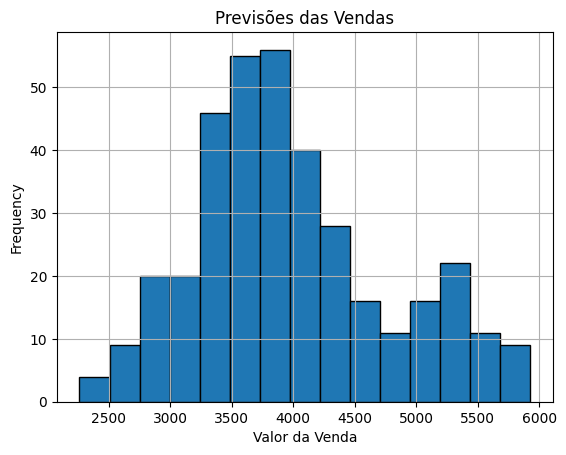

In [138]:
# Flatten the array of arrays into a single list
flat_data = [item for sublist in predictions for item in sublist]

# Count the frequency of each item
unique_items, frequencies = np.unique(flat_data, return_counts=True)

#print(unique_items)
#print(frequencies)

# Assuming you have a list of data points called 'data'
plt.hist(predictions, bins='auto', edgecolor='black')  # 'auto' for automatic bin size determination
plt.xlabel('Valor da Venda')
plt.ylabel('Frequency')
plt.title('Previsões das Vendas')
plt.grid(True)  # Add grid lines
plt.show()

In [139]:
# Assuming test_dataset is an instance of _SkipDataset
targets_test = []

# Iterate over the dataset to extract targets
for batch in test_dataset:
    inputs, target = batch  # Adjust this line according to the actual attribute/method name
    for value in target:
      targets_test.append(value)

targets_test = scaler.inverse_transform(targets_test)

print("Targets:", len(targets_test))

Targets: 363


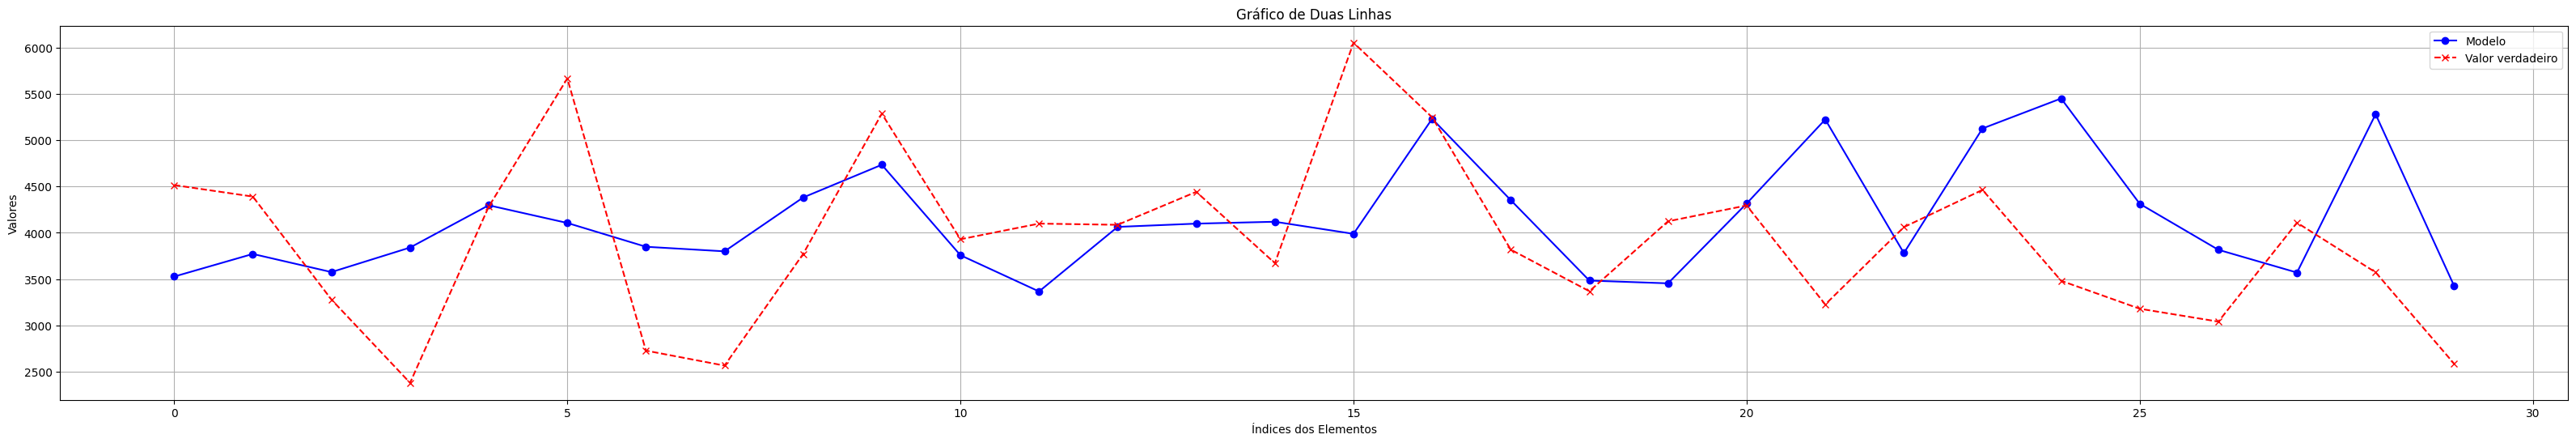

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Criar o gráfico de linhas
plt.plot(predictions[:30], label='Modelo', color='blue', linestyle='-', marker='o')
plt.plot(targets_test[:30], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(targets_test, predictions)

# MSE calculation
mse = mean_squared_error(targets_test, predictions)

# RMSE calculation (square root of MSE)
rmse = np.sqrt(mse)

In [142]:
mae

1032.2761598552142

In [143]:
mse

1683884.205379894

In [144]:
rmse

1297.6456393715096

In [145]:
sum(targets_test - predictions)/len(predictions)

array([38.75859022])

### Monte-Carlo dropout

In [146]:
# Make predictions with Monte Carlo Dropout
def predict_with_mc_dropout(model, dataset, num_samples):
    preds = []

    for _ in range(num_samples):
        predictions = model.predict(dataset)
        preds.append(predictions)

    return preds

# Example usage: assuming you have a dataset called 'test_dataset' for testing
num_samples = 250
preds = predict_with_mc_dropout(model, test_dataset, num_samples)
preds = [scaler.inverse_transform(preds[i].reshape(-1, 1)) for i in range(len(preds))]

12/12 [==============================] - 0s 3ms/step


In [147]:
len(preds)

250

In [148]:
[sublist[0] for sublist in preds]

[array([5716.], dtype=float32),
 array([4200.721], dtype=float32),
 array([2855.9812], dtype=float32),
 array([4285.693], dtype=float32),
 array([2974.6836], dtype=float32),
 array([3727.6956], dtype=float32),
 array([3641.6362], dtype=float32),
 array([4345.0757], dtype=float32),
 array([4164.766], dtype=float32),
 array([5302.436], dtype=float32),
 array([5427.3857], dtype=float32),
 array([5016.6245], dtype=float32),
 array([4147.4233], dtype=float32),
 array([5396.073], dtype=float32),
 array([3315.9873], dtype=float32),
 array([4057.5488], dtype=float32),
 array([3420.114], dtype=float32),
 array([4075.92], dtype=float32),
 array([2578.5417], dtype=float32),
 array([3788.8342], dtype=float32),
 array([3976.126], dtype=float32),
 array([3853.017], dtype=float32),
 array([5164.0713], dtype=float32),
 array([2266.3484], dtype=float32),
 array([2572.9597], dtype=float32),
 array([2418.91], dtype=float32),
 array([3995.4626], dtype=float32),
 array([4755.6914], dtype=float32),
 array([

In [149]:
mean_preds = np.mean(preds, axis=0)
var_preds = np.var(preds, axis=0)
sd_preds = np.sqrt(var_preds)

In [150]:
len(mean_preds)

363

In [151]:
len(sd_preds)

363

In [ ]:
#sd_preds

In [ ]:
sum(targets_test - mean_preds)/len(mean_preds)

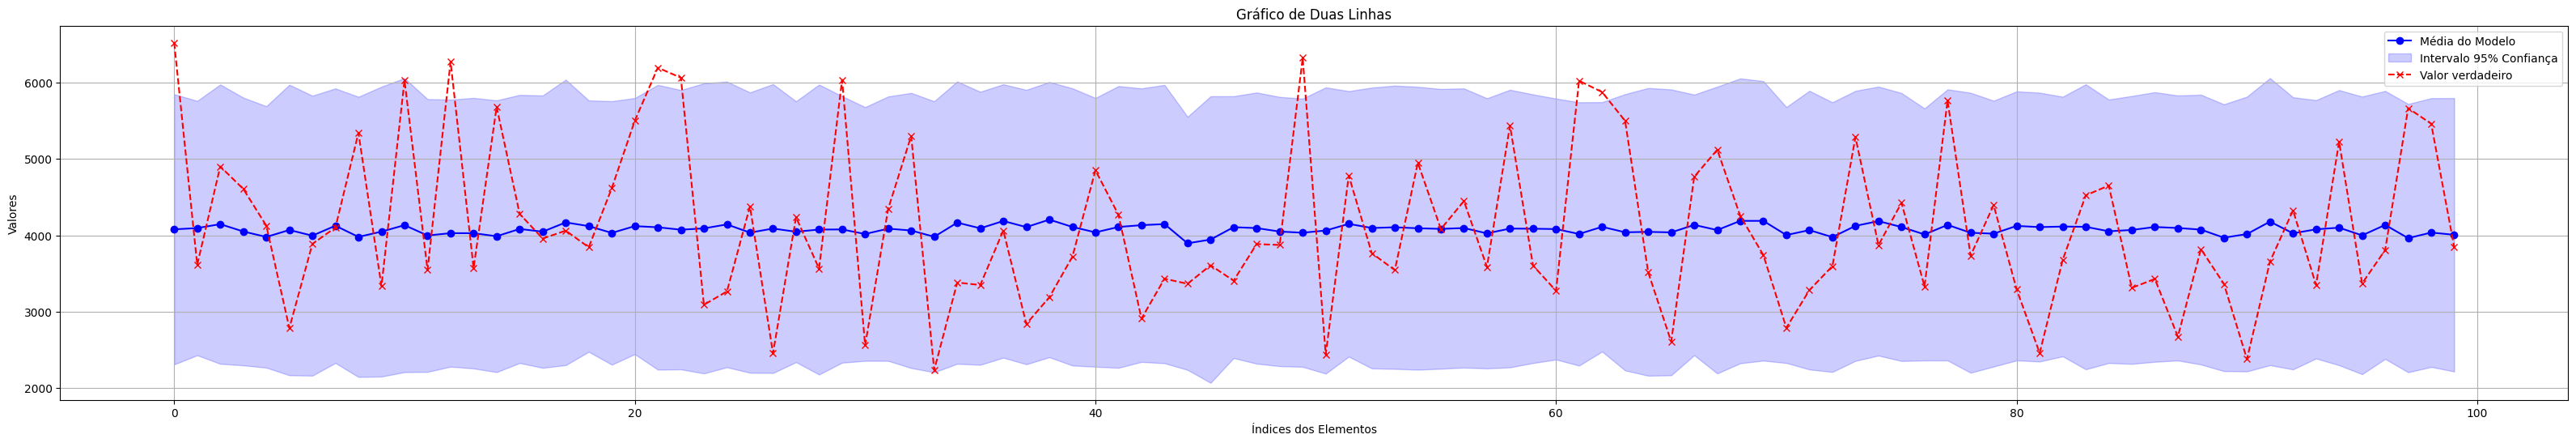

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Perform element-wise addition and subtraction
upper_bound = np.stack([mean + 1.96*sd for mean, sd in zip(mean_preds[:100], sd_preds[:100])]).ravel()
lower_bound = np.stack([mean - 1.96*sd for mean, sd in zip(mean_preds[:100], sd_preds[:100])]).ravel()

# Criar o gráfico de linhas
plt.plot(mean_preds[:100], label='Média do Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(100), lower_bound, upper_bound, color='blue', alpha=0.2, label='Intervalo 95% Confiança')
plt.plot(targets_test[:100], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

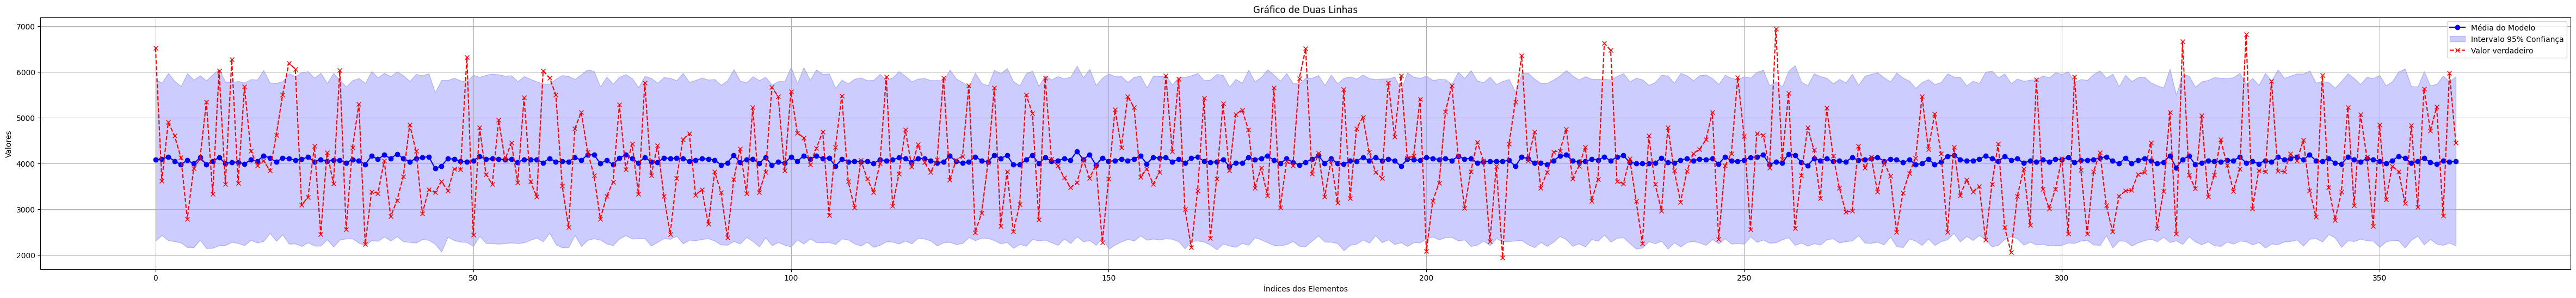

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(60, 6))

# Perform element-wise addition and subtraction
upper_bound = np.stack([mean + 1.96*sd for mean, sd in zip(mean_preds, sd_preds)]).ravel()
lower_bound = np.stack([mean - 1.96*sd for mean, sd in zip(mean_preds, sd_preds)]).ravel()

# Criar o gráfico de linhas
plt.plot(mean_preds, label='Média do Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(363), lower_bound, upper_bound, color='blue', alpha=0.2, label='Intervalo 95% Confiança')
plt.plot(targets_test, label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

### **Probabilistic** Bayesian Neural Network

In [133]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [134]:
import keras
from keras import layers
import tensorflow as tf
import tensorflow_probability as tfp

hidden_units = [50, 50]
learning_rate = 0.001

def create_probablistic_bnn_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    features = inputs
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / len(train_data_numpy),
            activation="sigmoid",
        )(features)

    # Create a probabilistic output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [135]:
import tensorflow as tf
from tensorflow.keras import layers, models

#'''
def run_experiment(model, loss, train_data_numpy, train_labels_numpy, test_dataset, num_epochs, learning_rate):
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_data_numpy, train_labels_numpy, epochs=num_epochs, validation_split=0.2)
    print("Model training finished.")

    print("Evaluating model performance on training dataset...")
    train_loss, train_rmse = model.evaluate(train_data_numpy, train_labels_numpy, verbose=0)
    print(f"Train RMSE: {round(train_rmse, 3)}")

    print("Evaluating model performance on test dataset...")
    test_loss, test_rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(test_rmse, 3)}")
#'''
# Assuming train_data_numpy, train_labels_numpy, and test_dataset are defined elsewhere
input_shape = (7, 5)  # Example shape, replace with actual shape
prob_bnn_model = create_probablistic_bnn_model(input_shape)

'''
def negative_loglikelihood(targets, estimated_distribution, log_variance):
    return -estimated_distribution.log_prob(targets, log_variance)
'''

def negative_log_likelihood(y_true, mean_log_variance):
    mean, log_variance = mean_log_variance[:, 0], mean_log_variance[:, 1]
    nll_loss = 0.5 * (log_variance + tf.square(y_true - mean) / tf.exp(log_variance)) + 0.5 * tf.math.log(2 * np.pi)
    return tf.reduce_mean(nll_loss)

num_epochs = 200
learning_rate = 0.001
loss_fn = tf.keras.losses.MeanSquaredError()

run_experiment(prob_bnn_model, negative_log_likelihood, train_data_numpy, train_labels_numpy, test_dataset, num_epochs, learning_rate)

Start training the model...
Epoch 1/50
19/39 [=============>................] - ETA: 0s - loss: 37.9813 - root_mean_squared_error: 2.2045

KeyboardInterrupt: 

In [ ]:
prediction_distribution = prob_bnn_model.predict(test_dataset)
# Reshape prediction_distribution to remove the extra dimension
prediction_distribution = np.squeeze(prediction_distribution)

# Now, you can use inverse_transform()
prediction_distribution = scaler.inverse_transform(prediction_distribution)
prediction_mean = np.mean(prediction_distribution, axis=1)
prediction_stdv = np.std(prediction_distribution, axis=1)

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

In [ ]:
prediction_distribution

In [ ]:
len(prediction_distribution[0])

In [ ]:
prediction_stdv

In [ ]:
upper, lower

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 6))

# Criar o gráfico de linhas
plt.plot(prediction_mean[:100], label='Média do Modelo', color='blue', linestyle='-', marker='o')
plt.fill_between(range(100), lower[:100], upper[:100], color='blue', alpha=0.2, label='Intervalo Confiança 95%')
plt.plot(targets_test[:100], label='Valor verdadeiro', color='red', linestyle='--', marker='x')

# Adicionar título e rótulos dos eixos
plt.title('Gráfico de Duas Linhas')
plt.xlabel('Índices dos Elementos')
plt.ylabel('Valores')

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.grid(True)
plt.show()

### Análises dos dados

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_time_series, model='additive', period=365)
decomposition.plot()
plt.show()

In [ ]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')
dot.node('E', f'LOJA 1', color='lightblue2', style='filled')
dot.node('F', f'LOJA 2', color='lightblue2', style='filled')
dot.node('G', f'LOJA 3', color='lightblue2', style='filled')
dot.node('H', f'LOJA 4', color='lightblue2', style='filled')
dot.node('I', f'LOJA 1', color='lightblue2', style='filled')
dot.node('J', f'LOJA 2', color='lightblue2', style='filled')
dot.node('K', f'LOJA 3', color='lightblue2', style='filled')
dot.node('L', f'LOJA 1', color='lightblue2', style='filled')
dot.node('M', f'LOJA 2', color='lightblue2', style='filled')
dot.node('N', f'LOJA 3', color='lightblue2', style='filled')
dot.node('JA', f'CATEGORY HOBBIES', color='lightblue2', style='filled')
dot.node('JB', f'CATEGORY FOOD', color='lightblue2', style='filled')
dot.node('JC', f'CATEGORY HOUSEHOLD', color='lightblue2', style='filled')
dot.node('JAA', f'DEPARTAMENT HOBBIES 1', color='lightblue2', style='filled')
dot.node('JAB', f'DEPARTAMENT HOBBIES 2', color='lightblue2', style='filled')
dot.node('JBA', f'DEPARTAMENT FOOD 1', color='lightblue2', style='filled')
dot.node('JBB', f'DEPARTAMENT FOOD 2', color='lightblue2', style='filled')
dot.node('JBC', f'DEPARTAMENT FOOD 3', color='lightblue2', style='filled')
dot.node('JCA', f'DEPARTAMENT HOUSEHOLD 1', color='lightblue2', style='filled')
dot.node('JCB', f'DEPARTAMENT HOUSEHOLD 2', color='lightblue2', style='filled')


dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('B', 'G')
dot.edge('B', 'H')
dot.edge('C', 'I')
dot.edge('C', 'J')
dot.edge('C', 'K')
dot.edge('D', 'L')
dot.edge('D', 'M')
dot.edge('D', 'N')
dot.edge('J', 'JA')
dot.edge('J', 'JB')
dot.edge('J', 'JC')
dot.edge('JA', 'JAA')
dot.edge('JA', 'JAB')
dot.edge('JB', 'JBA')
dot.edge('JB', 'JBB')
dot.edge('JB', 'JBC')
dot.edge('JC', 'JCA')
dot.edge('JC', 'JCB')

dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

In [ ]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado